# Project: Finding Lane Lines on the Road

## Import Packages

In [277]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


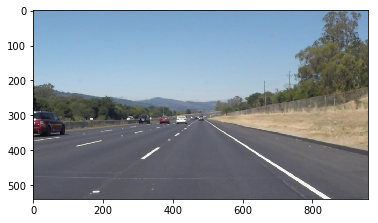

In [278]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [838]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Let's build the pipeline to work on the images in the directory "test_images".

In [280]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline

Let's build the pipeline that will draw lane lines on the test_images and run the solution on all test_images. Copies of images will be placed into the  `test_images_output` directory.

In [ ]:
# from os.path import isdir
import os

output_dir = 'test_images_output/'
if not os.path.exists(output_dir):
        os.mkdir(output_dir)
!mkdir test_images_output

# if not isdir(output_dir):
#     raise Exception("Test images Ouput directory doesn't exist!")
    
files = os.listdir("test_images/")
for filename in files:
    output_path = output_dir + filename[:-4]
    if not os.path.exists(output_path):
        os.mkdir(output_path)
        
    # Read in 
    image = mpimg.imread('test_images/' + filename)
    mpimg.imsave(output_path + "/" + filename, image)
    
    # grayscale the image
    gray = grayscale(image)
#     plt.imshow(gray, cmap='gray')
    mpimg.imsave(output_path + "/gray.jpg", gray, cmap='gray')
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
#     plt.imshow(edges, cmap='gray')

    mpimg.imsave(output_path + "/canny.jpg", edges, cmap='gray')
    
    # let's define a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(420, 330), (530, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    copy_color_img = image.copy()
    cv2.polylines(copy_color_img,[vertices], True,(255, 0, 0), thickness=2)
#     plt.imshow(copy_color_img)
    mpimg.imsave(output_path + "/roi.jpg", copy_color_img)
    
    # let's create a masked edges image
    masked_edges = region_of_interest(edges, vertices)
#     plt.imshow(masked_edges, cmap='gray')
    mpimg.imsave(output_path + "/masked_edges.jpg", masked_edges, cmap='gray')
    
    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 11 #minimum number of pixels making up a line
    max_line_gap = 16    # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
#     plt.imshow(line_img)

    mpimg.imsave(output_path + "/lines.jpg", line_img)
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = weighted_img(color_edges, line_img)
#     plt.imshow(lines_edges)

    mpimg.imsave(output_path + "/line_edges.jpg" , lines_edges)
    
    # Create a "color" copy of the initial image to combine with line image
    copy_color_img = image.copy()

    # Draw the lines on the edge image
    color_lines = weighted_img(copy_color_img, line_img)
    plt.imshow(color_lines)

    mpimg.imsave(output_path + "/lines_color.jpg", color_lines)

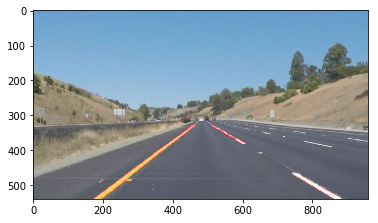

## Test on Videos

Let's draw lines over video. 
Let's test the solution on two provided videos:

solidWhiteRight.mp4

solidYellowLeft.mp4

If you get an error that looks like this:
```
NeedDownloadError: Need ffmpeg exe. 
```
You can download it by calling: 
```
imageio.plugins.ffmpeg.download()
```
Follow the instructions in the error message and check out this [forum](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) post for more troubleshooting tips across operating systems.

In [289]:
# import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [290]:
def process_image(image):
    # NOTE: The output should be a color image (3 channel) for processing video below
    # we should return the final output (image where lines are drawn on lanes)
    
    # Read in and grayscale the image
    gray = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # let's define a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(440, 330), (530, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # let's create a masked edges image
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 11 #minimum number of pixels making up a line
    max_line_gap = 16    # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a color copy of the initial image to combine with line image
    copy_color_img = image.copy()

    # Draw the lines on the edge image
    color_lines = weighted_img(copy_color_img, line_img)
    
    result = color_lines

    
    return result

Let's try the one with the solid white lane on the right first ...

In [291]:
!mkdir test_videos_output
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

mkdir: test_videos_output: File exists
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 77.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.95 s, sys: 658 ms, total: 3.61 s
Wall time: 3.21 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

**NOTE**: the video may fail to play in Safari but works well in Chrome.

In [294]:
HTML("""
<video width="960" height="540" controls>
  <source 
      src="{0}"
      type="video/mp4">
</video>
""".format(white_output))

## Improve the draw_lines() function

Let's define a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, let's try to average and/or extrapolate the line segments detected to map out the full extent of the lane lines. An example of the result can be seen in the video "P1_example.mp4".
Let's modify the draw_lines function accordingly and try re-running the pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.
Now for the one with the solid yellow lane on the left. This one's more tricky!

In [801]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def improved_draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # use the least mean square method to interploate
    # our discrete points with a polynome of first degree, i.e a line
    x_left = []
    y_left = []
    
    x_right = []
    y_right = []
    
    slope_bottom_bound = np.pi / 7 # around 25 degree
    slope_upper_bound = np.pi / 2 - np.pi / 9  #around  90 - 20 = 70 degree
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2 - x1 == 0:
                continue
                
            slope = (y2-y1)/(x2-x1)
            if slope < 0 and -0.5 < slope < -0.3:
                print("slope={}".format(slope))
                x_left.append(x1)
                x_left.append(x2)
                
                y_left.append(y1)
                y_left.append(y2)
            elif slope > 0 and slope_bottom_bound < slope < slope_upper_bound:
                x_right.append(x1)
                x_right.append(x2)
                
                y_right.append(y1)
                y_right.append(y2)

    # left line
    x = np.array(x_left)
    y = np.array(y_left)
    A = np.vstack([x, np.ones(len(x))]).T
    m1, b1 = np.linalg.lstsq(A, y)[0]
    
    
    y1 = img.shape[1]
    x1 = int((y1 - b1) / m1)
    
    y2 = 330
    x2 = int((y2 - b1) / m1)
    cv2.line(img, (x1, y1), (x2, y2), color, thickness=8)
    
    # right line
    x = np.array(x_right)
    y = np.array(y_right)
    A = np.vstack([x, np.ones(len(x))]).T
    m2, b2 = np.linalg.lstsq(A, y)[0]
    
    
    y1 = img.shape[1]
    x1 = int((y1 - b2) / m2)
    
    y2 = 330
    x2 = int((y2 - b2) / m2)
    cv2.line(img, (x1, y1), (x2, y2), color, thickness=8)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    improved_draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [814]:
def improved_process_image(image):
    # NOTE: The output should be a color image (3 channel) for processing video below
    # we should return the final output (image where lines are drawn on lanes)
    
    # Read in and grayscale the image
    gray = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # let's define a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(440, 330), (530, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # let's create a masked edges image
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a color copy of the initial image to combine with line image
    copy_color_img = image.copy()

    # Draw the lines on the edge image
    color_lines = weighted_img(copy_color_img, line_img)
    
    result = color_lines

    
    return result

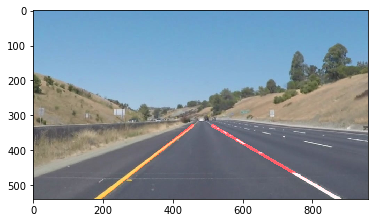

In [712]:
files = os.listdir("test_images/")
for filename in files:
#     print(filename)
    image = mpimg.imread('test_images/' + filename)
    output_image = improved_process_image(image)
    plt.imshow(output_image)

    mpimg.imsave(output_dir + "color_lines_" + filename, output_image)


In [739]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(14,15)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(improved_process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



100%|█████████▉| 681/682 [00:09<00:00, 70.59it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.84 s, sys: 2.08 s, total: 11.9 s
Wall time: 10.2 s


In [743]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(14,15)
clip2 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip2.fl_image(improved_process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:02<00:00, 78.79it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.95 s, sys: 662 ms, total: 3.61 s
Wall time: 3.22 s


## Challenge video

In [813]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(5,7)
# clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(improved_process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

slope=-0.32558139534883723
slope=-0.33076923076923076
slope=-0.423728813559322
slope=-0.3404255319148936
slope=-0.3684210526315789
slope=-0.3953488372093023
slope=-0.4
slope=-0.3333333333333333
slope=-0.4594594594594595
slope=-0.3333333333333333
slope=-0.30952380952380953
slope=-0.3125
slope=-0.4444444444444444
slope=-0.3076923076923077
slope=-0.3333333333333333
slope=-0.4090909090909091
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



  6%|▌         | 3/51 [00:00<00:01, 29.33it/s]

slope=-0.32558139534883723
slope=-0.33076923076923076
slope=-0.423728813559322
slope=-0.3404255319148936
slope=-0.3684210526315789
slope=-0.3953488372093023
slope=-0.4
slope=-0.3333333333333333
slope=-0.4594594594594595
slope=-0.3333333333333333
slope=-0.30952380952380953
slope=-0.3125
slope=-0.4444444444444444
slope=-0.3076923076923077
slope=-0.3333333333333333
slope=-0.4090909090909091
slope=-0.3249097472924188
slope=-0.32432432432432434
slope=-0.4189189189189189
slope=-0.3333333333333333
slope=-0.3448275862068966
slope=-0.3225806451612903
slope=-0.32142857142857145
slope=-0.32432432432432434
slope=-0.4230769230769231
slope=-0.45454545454545453
slope=-0.30303030303030304
slope=-0.38461538461538464
slope=-0.3254437869822485
slope=-0.4666666666666667
slope=-0.42857142857142855
slope=-0.47368421052631576
slope=-0.4375
slope=-0.36363636363636365
slope=-0.4482758620689655
slope=-0.42857142857142855
slope=-0.42857142857142855
slope=-0.39285714285714285
slope=-0.3157894736842105
slope=-0.36


 14%|█▎        | 7/51 [00:00<00:01, 30.10it/s]


slope=-0.45454545454545453
slope=-0.4888888888888889
slope=-0.42857142857142855
slope=-0.3333333333333333
slope=-0.45454545454545453
slope=-0.4482758620689655
slope=-0.30434782608695654
slope=-0.3333333333333333
slope=-0.3076923076923077
slope=-0.3333333333333333
slope=-0.45454545454545453
slope=-0.45454545454545453
slope=-0.3235294117647059
slope=-0.42857142857142855
slope=-0.3375
slope=-0.46153846153846156
slope=-0.3381294964028777
slope=-0.3401015228426396
slope=-0.38461538461538464
slope=-0.3764705882352941
slope=-0.3333333333333333
slope=-0.47058823529411764
slope=-0.32
slope=-0.37142857142857144
slope=-0.35294117647058826



 20%|█▉        | 10/51 [00:00<00:01, 29.50it/s]

slope=-0.33613445378151263
slope=-0.3273809523809524
slope=-0.35714285714285715
slope=-0.4375
slope=-0.3076923076923077
slope=-0.44
slope=-0.4
slope=-0.3076923076923077
slope=-0.4230769230769231
slope=-0.40625
slope=-0.45454545454545453
slope=-0.36363636363636365
slope=-0.3333333333333333
slope=-0.36363636363636365
slope=-0.3253968253968254
slope=-0.4666666666666667
slope=-0.45714285714285713
slope=-0.3023255813953488
slope=-0.3888888888888889
slope=-0.3333333333333333
slope=-0.3333333333333333
slope=-0.32
slope=-0.32679738562091504
slope=-0.36363636363636365
slope=-0.32894736842105265
slope=-0.38461538461538464
slope=-0.4
slope=-0.41379310344827586
slope=-0.3793103448275862
slope=-0.46153846153846156
slope=-0.4666666666666667
slope=-0.4
slope=-0.35714285714285715
slope=-0.34146341463414637
slope=-0.3282442748091603
slope=-0.32407407407407407
slope=-0.44
slope=-0.4
slope=-0.4583333333333333
slope=-0.36363636363636365
slope=-0.30434782608695654
slope=-0.45
slope=-0.38095238095238093
slo


slope=-0.3142857142857143
slope=-0.30666666666666664
slope=-0.4411764705882353
slope=-0.3333333333333333
slope=-0.3090909090909091
slope=-0.3142857142857143
slope=-0.375
slope=-0.30303030303030304
slope=-0.3333333333333333
slope=-0.3333333333333333


 33%|███▎      | 17/51 [00:00<00:01, 29.56it/s]


slope=-0.32075471698113206
slope=-0.45454545454545453
slope=-0.4666666666666667
slope=-0.3425925925925926
slope=-0.4594594594594595
slope=-0.4444444444444444
slope=-0.3018867924528302
slope=-0.3191489361702128
slope=-0.42857142857142855
slope=-0.3157894736842105
slope=-0.32894736842105265
slope=-0.3125
slope=-0.4594594594594595
slope=-0.31645569620253167
slope=-0.32558139534883723
slope=-0.3023255813953488
slope=-0.3225806451612903
slope=-0.3090909090909091
slope=-0.45454545454545453
slope=-0.34782608695652173
slope=-0.4230769230769231
slope=-0.3333333333333333
slope=-0.45454545454545453
slope=-0.3076923076923077
slope=-0.3684210526315789
slope=-0.3103448275862069
slope=-0.3333333333333333
slope=-0.3333333333333333
slope=-0.3548387096774194
slope=-0.37037037037037035
slope=-0.4461538461538462
slope=-0.32727272727272727
slope=-0.3055555555555556
slope=-0.3125
slope=-0.3103448275862069
slope=-0.38
slope=-0.3118279569892473
slope=-0.3018867924528302
slope=-0.3181818181818182
slope=-0.301


 39%|███▉      | 20/51 [00:00<00:01, 29.03it/s]

slope=-0.3023255813953488
slope=-0.32
slope=-0.3023255813953488
slope=-0.3409090909090909
slope=-0.40625
slope=-0.3157894736842105
slope=-0.43478260869565216
slope=-0.42857142857142855
slope=-0.34782608695652173
slope=-0.3076923076923077
slope=-0.35714285714285715
slope=-0.36363636363636365
slope=-0.4057971014492754
slope=-0.3181818181818182
slope=-0.3157894736842105
slope=-0.41379310344827586
slope=-0.391304347826087
slope=-0.4166666666666667
slope=-0.4166666666666667
slope=-0.3225806451612903
slope=-0.4
slope=-0.38461538461538464
slope=-0.3333333333333333
slope=-0.45
slope=-0.36363636363636365
slope=-0.4
slope=-0.3076923076923077
slope=-0.4
slope=-0.30434782608695654
slope=-0.3333333333333333
slope=-0.4025974025974026
slope=-0.3333333333333333
slope=-0.3076923076923077
slope=-0.375
slope=-0.3333333333333333
slope=-0.3684210526315789
slope=-0.35
slope=-0.4
slope=-0.35294117647058826
slope=-0.38461538461538464
slope=-0.42424242424242425
slope=-0.3448275862068966
slope=-0.36363636363636


 45%|████▌     | 23/51 [00:00<00:01, 25.77it/s]

slope=-0.375
slope=-0.41379310344827586
slope=-0.42105263157894735
slope=-0.3023255813953488
slope=-0.4
slope=-0.32653061224489793
slope=-0.32142857142857145
slope=-0.4074074074074074
slope=-0.3488372093023256
slope=-0.32
slope=-0.38461538461538464
slope=-0.3333333333333333
slope=-0.40540540540540543
slope=-0.30357142857142855
slope=-0.30612244897959184
slope=-0.3225806451612903
slope=-0.30612244897959184
slope=-0.36363636363636365
slope=-0.391304347826087
slope=-0.35294117647058826
slope=-0.3333333333333333
slope=-0.3333333333333333
slope=-0.42105263157894735
slope=-0.4482758620689655
slope=-0.47058823529411764
slope=-0.3157894736842105
slope=-0.4782608695652174
slope=-0.32
slope=-0.4117647058823529
slope=-0.38095238095238093
slope=-0.36363636363636365
slope=-0.4666666666666667
slope=-0.36231884057971014
slope=-0.3333333333333333


 51%|█████     | 26/51 [00:00<00:01, 24.64it/s]


slope=-0.35789473684210527
slope=-0.3870967741935484
slope=-0.3382352941176471
slope=-0.3050847457627119
slope=-0.4262295081967213
slope=-0.3333333333333333
slope=-0.32
slope=-0.3333333333333333
slope=-0.42105263157894735
slope=-0.45454545454545453
slope=-0.3333333333333333
slope=-0.36363636363636365
slope=-0.4
slope=-0.3125
slope=-0.46153846153846156
slope=-0.375
slope=-0.45454545454545453
slope=-0.391304347826087
slope=-0.3333333333333333
slope=-0.4166666666666667
slope=-0.34782608695652173
slope=-0.30434782608695654
slope=-0.38461538461538464
slope=-0.3333333333333333
slope=-0.36363636363636365
slope=-0.3684210526315789
slope=-0.3815789473684211
slope=-0.36486486486486486
slope=-0.3333333333333333
slope=-0.3235294117647059
slope=-0.4375
slope=-0.34210526315789475
slope=-0.3333333333333333
slope=-0.3125
slope=-0.4090909090909091
slope=-0.391304347826087
slope=-0.34782608695652173
slope=-0.3333333333333333
slope=-0.4166666666666667
slope=-0.3333333333333333
slope=-0.4117647058823529



 57%|█████▋    | 29/51 [00:01<00:00, 25.90it/s]


slope=-0.43478260869565216
slope=-0.36363636363636365
slope=-0.3333333333333333
slope=-0.38461538461538464
slope=-0.3684210526315789
slope=-0.3076923076923077
slope=-0.375
slope=-0.46153846153846156
slope=-0.3125
slope=-0.375
slope=-0.4431818181818182
slope=-0.36363636363636365
slope=-0.36666666666666664
slope=-0.40625
slope=-0.4230769230769231
slope=-0.391304347826087
slope=-0.3333333333333333
slope=-0.3684210526315789
slope=-0.38461538461538464
slope=-0.3333333333333333
slope=-0.36507936507936506
slope=-0.375
slope=-0.32432432432432434
slope=-0.375
slope=-0.42105263157894735
slope=-0.3181818181818182
slope=-0.44
slope=-0.36363636363636365
slope=-0.42105263157894735
slope=-0.42857142857142855
slope=-0.4583333333333333
slope=-0.36363636363636365
slope=-0.3076923076923077
slope=-0.37037037037037035
slope=-0.4117647058823529
slope=-0.38461538461538464
slope=-0.42105263157894735
slope=-0.3103448275862069



 63%|██████▎   | 32/51 [00:01<00:00, 26.22it/s]

slope=-0.375
slope=-0.4423076923076923
slope=-0.4230769230769231
slope=-0.425
slope=-0.42857142857142855
slope=-0.4444444444444444
slope=-0.3333333333333333
slope=-0.3333333333333333
slope=-0.3125
slope=-0.4583333333333333
slope=-0.3611111111111111
slope=-0.4166666666666667
slope=-0.37037037037037035
slope=-0.35
slope=-0.30303030303030304
slope=-0.3076923076923077
slope=-0.3333333333333333
slope=-0.45454545454545453
slope=-0.36363636363636365
slope=-0.4
slope=-0.4
slope=-0.4
slope=-0.4166666666666667
slope=-0.375
slope=-0.35294117647058826
slope=-0.3333333333333333
slope=-0.4375
slope=-0.36363636363636365
slope=-0.45454545454545453
slope=-0.4166666666666667
slope=-0.45454545454545453
slope=-0.47368421052631576
slope=-0.36363636363636365
slope=-0.4666666666666667
slope=-0.3076923076923077
slope=-0.4
slope=-0.35714285714285715
slope=-0.36
slope=-0.3888888888888889
slope=-0.3076923076923077
slope=-0.4090909090909091
slope=-0.3888888888888889
slope=-0.36363636363636365
slope=-0.31428571428


 71%|███████   | 36/51 [00:01<00:00, 28.09it/s]

slope=-0.47619047619047616
slope=-0.4
slope=-0.4576271186440678
slope=-0.46938775510204084
slope=-0.4166666666666667
slope=-0.4444444444444444
slope=-0.42857142857142855
slope=-0.36363636363636365
slope=-0.40625
slope=-0.38461538461538464
slope=-0.4444444444444444
slope=-0.3235294117647059
slope=-0.4666666666666667
slope=-0.4166666666666667
slope=-0.4727272727272727
slope=-0.36363636363636365
slope=-0.46153846153846156
slope=-0.4
slope=-0.3333333333333333
slope=-0.49137931034482757
slope=-0.45
slope=-0.3076923076923077
slope=-0.325
slope=-0.32653061224489793
slope=-0.42105263157894735
slope=-0.36363636363636365
slope=-0.34782608695652173
slope=-0.3191489361702128



 78%|███████▊  | 40/51 [00:01<00:00, 29.88it/s]

slope=-0.40476190476190477
slope=-0.43859649122807015
slope=-0.35294117647058826
slope=-0.425
slope=-0.3939393939393939
slope=-0.45
slope=-0.4
slope=-0.45454545454545453
slope=-0.4230769230769231
slope=-0.4230769230769231
slope=-0.45161290322580644
slope=-0.4
slope=-0.4827586206896552
slope=-0.47368421052631576
slope=-0.47368421052631576
slope=-0.45454545454545453
slope=-0.30303030303030304
slope=-0.4642857142857143
slope=-0.3023255813953488
slope=-0.35294117647058826
slope=-0.4
slope=-0.4473684210526316
slope=-0.45454545454545453
slope=-0.3333333333333333


slope=-0.43103448275862066
slope=-0.36363636363636365
slope=-0.425531914893617
slope=-0.4857142857142857
slope=-0.46511627906976744
slope=-0.43478260869565216
slope=-0.3442622950819672
slope=-0.3076923076923077
slope=-0.4166666666666667
slope=-0.4642857142857143
slope=-0.42857142857142855
slope=-0.425
slope=-0.4074074074074074
slope=-0.4375
slope=-0.36363636363636365



 86%|████████▋ | 44/51 [00:01<00:00, 30.86it/s]

slope=-0.40816326530612246
slope=-0.36507936507936506
slope=-0.47368421052631576
slope=-0.42857142857142855
slope=-0.3125
slope=-0.42857142857142855
slope=-0.3150684931506849
slope=-0.47619047619047616
slope=-0.4375
slope=-0.38181818181818183
slope=-0.45454545454545453
slope=-0.4423076923076923
slope=-0.3225806451612903
slope=-0.3114754098360656
slope=-0.3010752688172043
slope=-0.4423076923076923
slope=-0.37209302325581395
slope=-0.45454545454545453



 94%|█████████▍| 48/51 [00:01<00:00, 29.92it/s]

slope=-0.3034825870646766
slope=-0.4666666666666667
slope=-0.3870967741935484
slope=-0.3333333333333333
slope=-0.4166666666666667
slope=-0.4166666666666667
slope=-0.32
slope=-0.3076923076923077



 98%|█████████▊| 50/51 [00:01<00:00, 28.84it/s]

slope=-0.31746031746031744
slope=-0.37209302325581395
slope=-0.3333333333333333
slope=-0.43636363636363634
slope=-0.4
slope=-0.43283582089552236


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1.99 s, sys: 327 ms, total: 2.32 s
Wall time: 2.88 s
